In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calplot
from scipy.stats import pearsonr
from matplotlib.ticker import StrMethodFormatter

In [2]:
prf = pd.read_csv('~data/prf.csv')
prf

,EUBWID,label,predictedAt,publishedAt,expiresAt,warning,riskLevelLabel
0,ukc1101-06000,Seaton Carew North,2020-05-14T08:30:00,2020-05-14T14:38:44,2020-05-15T08:29:00,No warnings in place,normal
1,ukc1101-06000,Seaton Carew North,2020-05-15T08:30:00,2020-05-15T08:40:44,2020-05-16T08:29:00,No warnings in place,normal
2,ukc1101-06000,Seaton Carew North,2020-05-16T08:30:00,2020-05-16T08:41:19,2020-05-17T08:29:00,No warnings in place,normal
3,ukc1101-06000,Seaton Carew North,2020-05-17T08:30:00,2020-05-17T08:41:49,2020-05-18T08:29:00,No warnings in place,normal
4,ukc1101-06000,Seaton Carew North,2020-05-18T08:30:00,2020-05-18T08:42:09,2020-05-19T08:29:00,No warnings in place,normal
...,...,...,...,...,...,...,...
207259,ukk4307-33900,Westward Ho!,2023-06-08T08:30:00,2023-06-08T08:40:54,2023-06-09T08:29:00,No pollution incidents reported,normal
207260,ukk4307-33900,Westward Ho!,2023-06-09T08:30:00,2023-06-09T08:40:54,2023-06-10T08:29:00,No pollution incidents reported,normal
207261,ukk4307-33900,Westward Ho!,2023-06-10T08:30:00,2023-06-10T08:41:24,2023-06-11T08:29:00,No pollution incidents reported,normal
207262,ukk4307-33900,Westward Ho!,2023-06-11T08:30:00,2023-06-11T08:40:54,2023-06-12T08:29:00,No pollution incidents reported,normal


In [3]:
prf['time'] = pd.to_datetime(prf['predictedAt']).dt.strftime('%Y-%m-%d')
prf.drop(['label', 'predictedAt', 'publishedAt', 'expiresAt', 'warning'], axis=1, inplace=True)
prf.rename({'EUBWID':'site'}, axis=1, inplace=True)
prf = prf[prf['riskLevelLabel'] != 'no-prediction']
prf = prf.groupby(['site', 'time'])['riskLevelLabel'].max().reset_index()
prf['time'] = pd.to_datetime(prf['time'])
prf = prf[(prf['time'].dt.year >= 2020) & (prf['time'].dt.year <= 2022)]
prf

,site,time,riskLevelLabel
0,ukc1101-06000,2020-05-14,normal
1,ukc1101-06000,2020-05-15,normal
2,ukc1101-06000,2020-05-16,normal
3,ukc1101-06000,2020-05-17,normal
4,ukc1101-06000,2020-05-18,normal
...,...,...,...
207010,ukk4307-33900,2022-09-26,normal
207011,ukk4307-33900,2022-09-27,normal
207012,ukk4307-33900,2022-09-28,normal
207013,ukk4307-33900,2022-09-29,normal


In [4]:
len(prf['site'].unique())

424

In [5]:
len(prf['time'].unique())

512

## Imbalanced Data

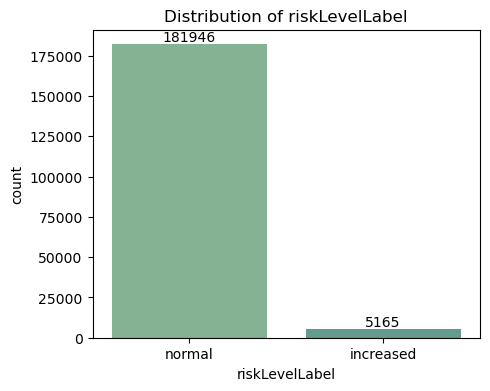

In [6]:
plt.figure(figsize=[5,4])
sns.set_palette("crest")

ax = sns.countplot(x='riskLevelLabel', data=prf)
plt.title('Distribution of riskLevelLabel')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

In [7]:
prf["riskLevelLabel"].replace({"normal": 0, "increased": 1}, inplace=True)
prf.to_csv('~data/pollution_risk_forecasting.csv', index=False)

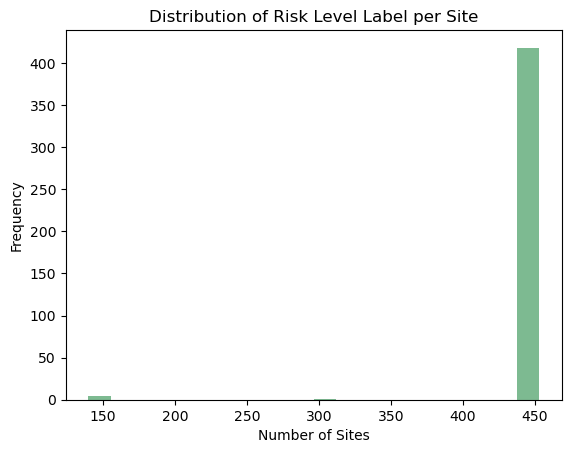

In [8]:
counts_per_site = prf.groupby('site').count().sort_values(by='riskLevelLabel')['time']
counts_per_site.plot.hist(bins=20)
plt.title('Distribution of Risk Level Label per Site')
plt.xlabel('Number of Sites')
plt.ylabel('Frequency')
plt.show()

## Missing Values

In [9]:
unique_pairs = prf.groupby('time')['site'].nunique()
percentage_list = [[index, value] for index, value in unique_pairs.items()]

pct = pd.DataFrame(percentage_list, columns = ['time','Percentage'])
pct['time'] = pd.to_datetime(pct['time'])
pct = pct.set_index('time')

(<Figure size 3000x1300 with 4 Axes>,
 array([<Axes: ylabel='2020'>, <Axes: ylabel='2021'>,
        <Axes: ylabel='2022'>], dtype=object))

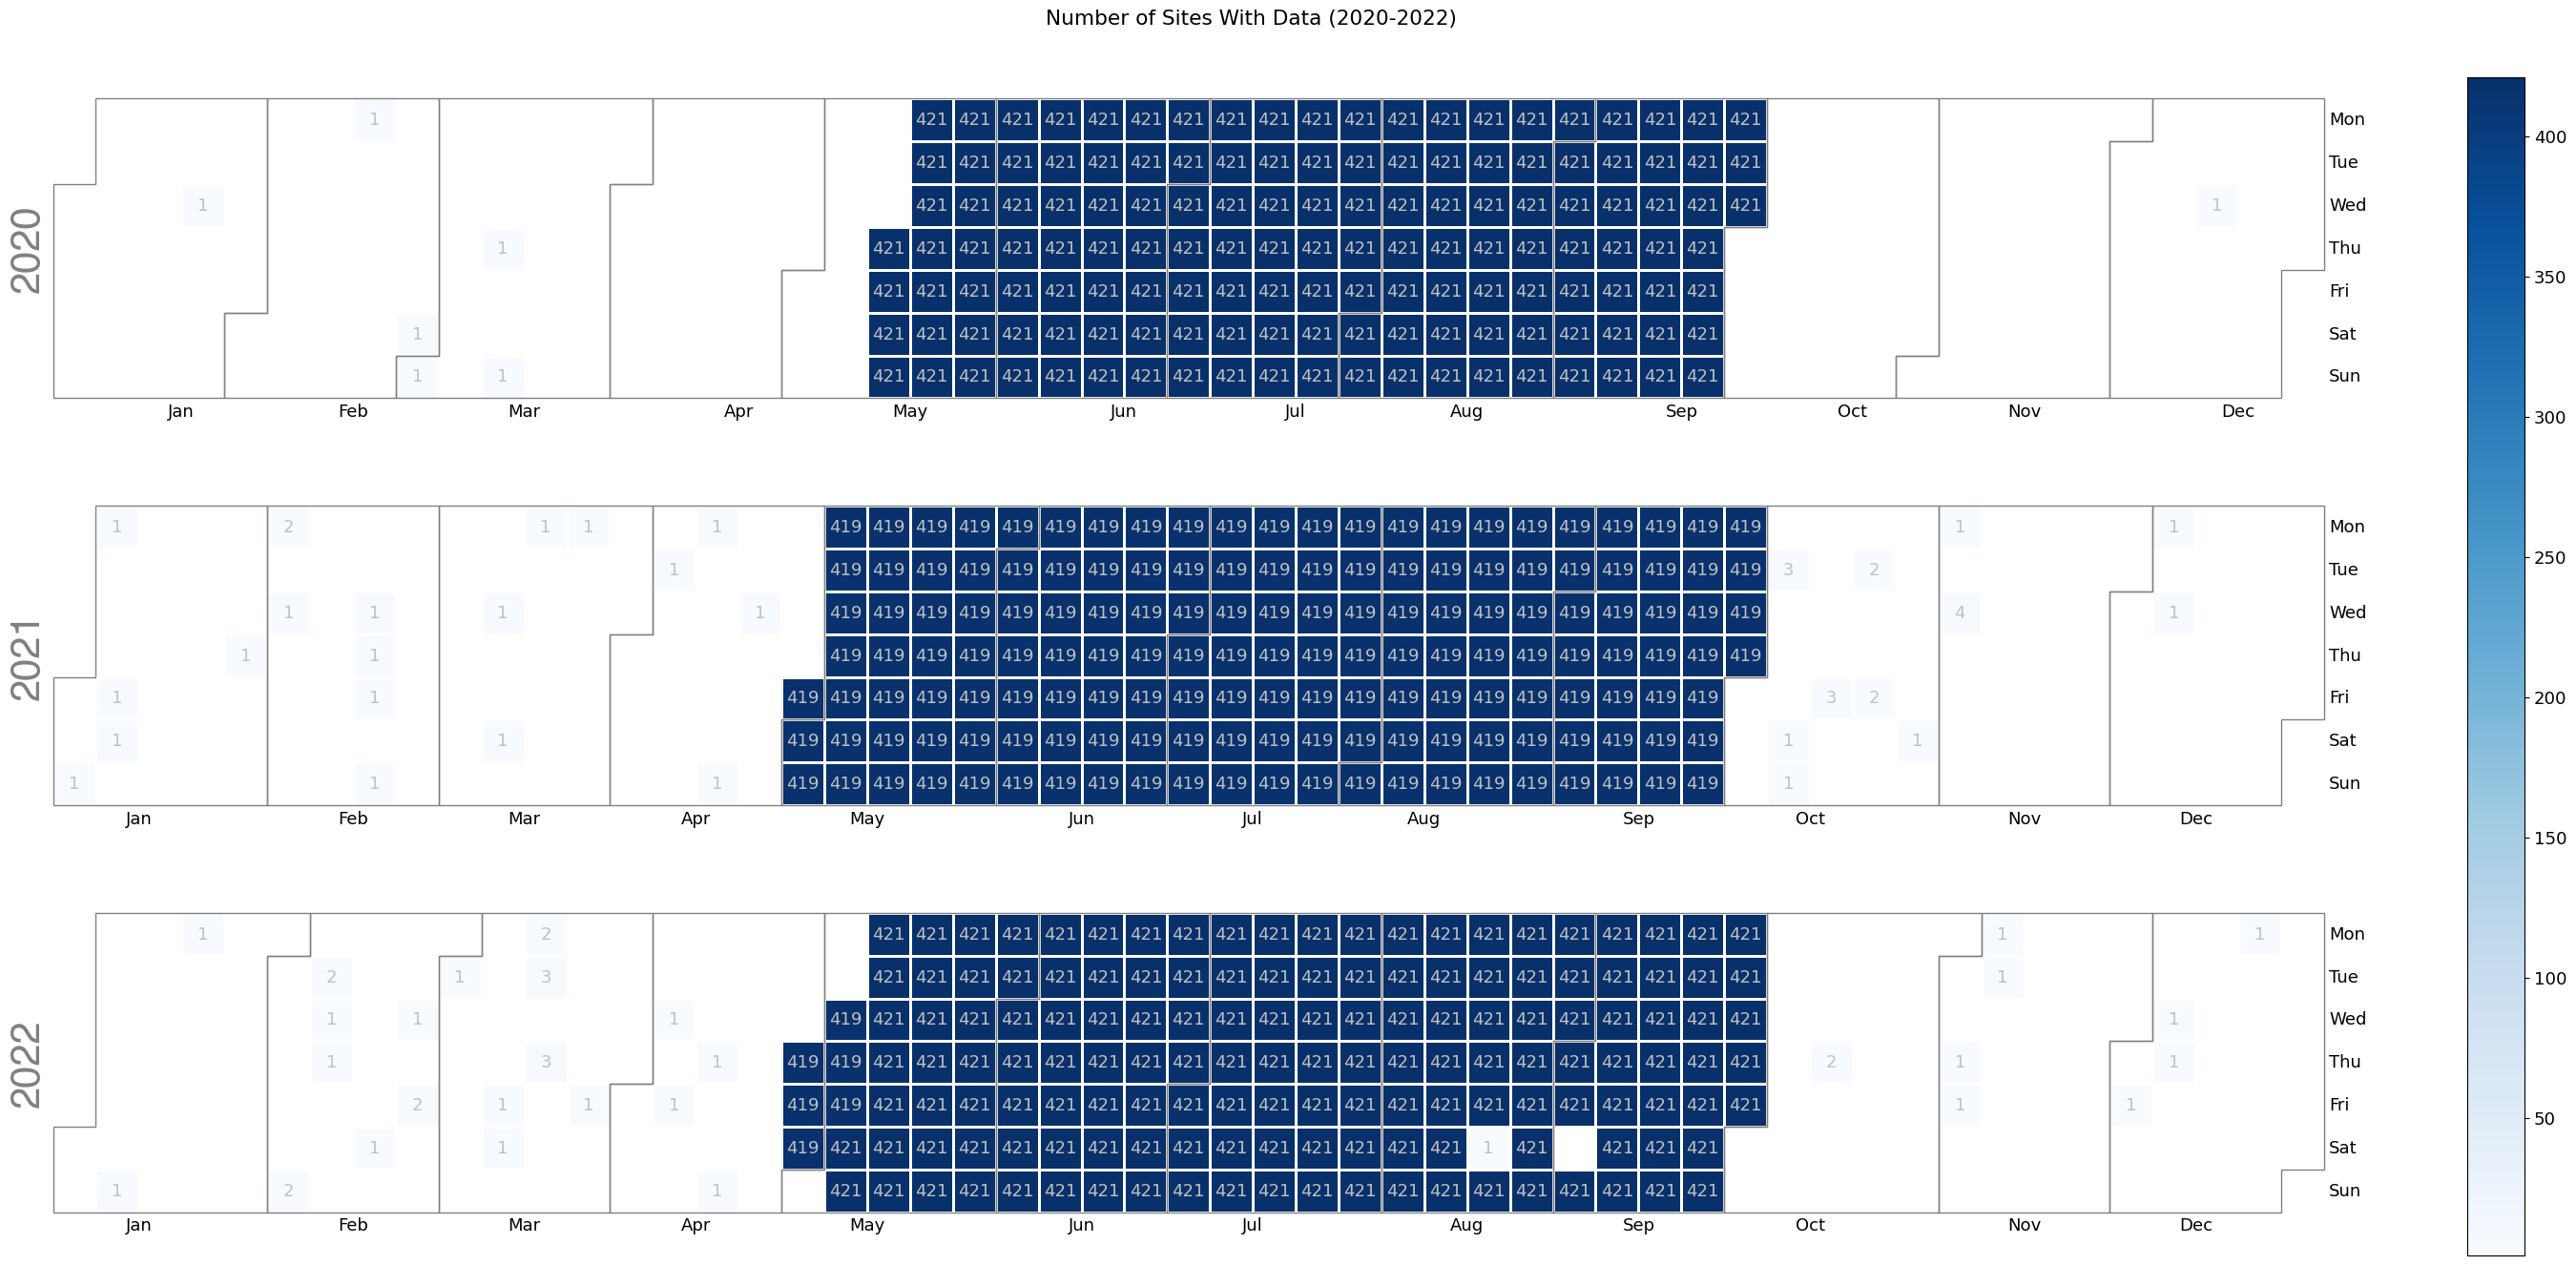

In [10]:
plt.rcParams['font.size'] = '13'

calplot.calplot(data = pct['Percentage'], how = 'sum', cmap = 'Blues', yearlabels = True,
                figsize = (30, 13), textformat='{:.0f}', textcolor = 'silver', fillcolor='w', 
                suptitle = "Number of Sites With Data (2020-2022)")